In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from numba import jit
from sklearn.cluster import DBSCAN
from collections import Counter
from scipy.stats import cramervonmises
from scipy.stats import zscore
from scipy.stats import norm
import seaborn as sns
from scipy.spatial import distance
from numpy.random import choice
from scipy.stats import ttest_ind

In [5]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['font.size'] = 15
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["text.usetex"] = False

In [6]:
micron_per_pixel = 1.0/23.5 # Value from Salman

In [7]:
def cluster_points(points, epsilon=2.0, min_samples=3):
    """ Function to apply DBSCAN:
    
    Inputs:
    -------
    points (numpy.2darray): A list of (x,y) coordinates of the different points
    epsilon (float): Distance (in microns) within which points are considered neighbors
    min_samples (int): Minimum number of points in each cluster
    
    Outputs:
    clusters (numpy.1darray): Same size as points. Each point is assigned a cluster number.
    """
    
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    clusters = dbscan.fit_predict(points)
    return clusters

In [8]:
def visualize_clustering_performance(points_size_dict, min_num_per_cluster):
    
    cluster_sizes = []

    for key in points_size_dict['points'].keys(): 

        clusters = points_size_dict['clusters'][key]
        points = points_size_dict['points'][key]

        counts_of_points_in_clusters = Counter(clusters)
        cluster_sizes += [counts for counts in counts_of_points_in_clusters.values()]

        # Coloring clusters randomly
        color_array = np.arange(np.max(clusters)+1)
        np.random.shuffle(color_array)
        color_assignments = [color_array[clust_num] for clust_num in clusters]

        # Visualize the clusters
        plt.scatter(points[:, 0], points[:, 1], s=5, c=color_assignments, cmap='hsv')
        plt.xlabel(r'X ($\mu$ m)')
        plt.ylabel(r'Y ($\mu$ m)')
        plt.title(key)
        plt.show()
        plt.close()

    fig, axs = plt.subplots(1,1,figsize=(3,3))
    axs.hist(cluster_sizes, edgecolor='k', color='g', alpha=0.6)
    axs.set_xlabel('Cluster size')
    axs.set_ylabel('Counts')
    plt.show()
    plt.close()

    print('Total number of clusters: ', str(len(cluster_sizes)))

    print('Total number of clusters with at least ', str(min_num_per_cluster), ' points is:' ,
          str(len(np.where(np.array(cluster_sizes) > min_num_per_cluster)[0])))

In [9]:
def lsw_pdf(r, mean=1.0):
    """Function to compute the probability density according to the Lifschitz-Wagner-Slyozov 
    distribution for coarsening"""
    pdf = np.zeros(len(r))
    for i in range(len(r)):
        # LSW CDF reaches the value of 1 at 1.5*mean and doesn't change after that. 
        if r[i] > 1.5*mean:
            pdf[i] = 0.0
        else:
            pdf[i] = (1.0/mean)*(4/9)*(r[i]/mean)**2 *(1 + r[i]/(3*mean))**(-7/3)*(1 - (2*r[i])/(3*mean))**(-11/3)*np.exp((2*r[i])/(3*mean)/((2*r[i])/(3*mean) - 1))
    return pdf

def lsw_cdf(r, mean=1.0, dr=0.01):
    """Calculate the cumulative distribution function from the lsw distribution for a particular value of r""" 
    cdf = np.zeros(len(r))
    r_range = np.arange(np.min(r), np.max(r), dr)
    pdf = lsw_pdf(r=r_range, mean=mean)
    for i in range(len(r)):
        cdf[i] = np.sum(pdf[r_range < r[i]])/np.sum(pdf)
    return cdf

In [30]:
# Get the Z scores of the FC sizes in different clusters and compare the distribution shapes

def fit_and_compare_distributions(points_size_dict, min_num_per_cluster, figname):

    z_values = np.array([], dtype=float)
    log_z_values = np.array([], dtype=float)
    lsw_norm_values = np.array([], dtype=float)

    for key in points_size_dict['points'].keys(): 

        points = points_size_dict['points'][key]
        radii = points_size_dict['size'][key]
        clusters = points_size_dict['clusters'][key]
        counts_of_points_in_clusters = Counter(clusters)

        for clust_num, counts in counts_of_points_in_clusters.items():
            if counts >= min_num_per_cluster and clust_num >=0:
                radii_in_cluster = radii[clusters == clust_num]    
                z_values = np.append(z_values, zscore(radii_in_cluster))
                lsw_norm_values = np.append(lsw_norm_values, radii_in_cluster/np.mean(radii_in_cluster))
                log_z_values = np.append(log_z_values, zscore(np.log(radii_in_cluster)))

    # Cramer Von Mises test for normal distribution

    result = cramervonmises(z_values, cdf='norm')
    print(result)

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].hist(z_values, bins=40, density=True, cumulative=True, alpha=0.6, color='g', label='Data')
    axs[1].hist(z_values, bins=20, density=True, alpha=0.6, color='g', label='Data')

    x = np.linspace(np.min(z_values), np.max(z_values), 100)
    cum_d = norm.cdf(x, 0.0, 1.0)
    prob_d = norm.pdf(x, 0.0, 1.0)
    axs[0].plot(x, cum_d, 'k', linewidth=2, label='Normal \nDistribution')
    axs[1].plot(x, prob_d, 'k', linewidth=2, label='Normal \nDistribution')

    # plt.title('Normal Distribution')
    # plt.xlabel(r'$z_{normal} = (x-\mu)/\sigma$')
    axs[0].set_xlabel(r'Z$_{normal}$')
    axs[0].set_ylabel('Cumulative distribution function')
    axs[1].set_xlabel(r'Z$_{normal}$')
    axs[1].set_ylabel('Probability density')

    axs[0].legend(fontsize=10)
    axs[1].legend(fontsize=10)
    plt.tight_layout()
    plt.savefig('Figures_for_paper/' + figname + '_normal.pdf', format='pdf', dpi=600)
    plt.savefig('Figures_for_paper/' + figname + '.svg', format='svg', dpi=600)
    plt.show()
    plt.close()

    # Cramer Von Mises test for log normal distribution

    result = cramervonmises(log_z_values, cdf='norm')
    print(result)

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].hist(log_z_values, bins=40, density=True, cumulative=True, alpha=0.6, color='g', label='Data')
    axs[1].hist(log_z_values, bins=20, density=True, alpha=0.6, color='g', label='Data')

    x = np.linspace(np.min(log_z_values), np.max(log_z_values), 100)
    cum_d = norm.cdf(x, 0.0, 1.0)
    prob_d = norm.pdf(x, 0.0, 1.0)
    axs[0].plot(x, cum_d, 'k', linewidth=2, label='Log Normal \nDistribution')
    axs[1].plot(x, prob_d, 'k', linewidth=2, label='Log Normal \nDistribution')

    # plt.title('Normal Distribution')
    # plt.xlabel(r'$z_{normal} = (x-\mu)/\sigma$')
    axs[0].set_xlabel(r'Z$_{log~normal}$')
    axs[0].set_ylabel('Cumulative distribution function')
    axs[1].set_xlabel(r'Z$_{log~normal}$')
    axs[1].set_ylabel('Probability density')

    axs[0].legend(fontsize=10)
    axs[1].legend(fontsize=10)

    plt.tight_layout()
    plt.savefig('Figures_for_paper/' + figname + '_log_normal.pdf', format='pdf', dpi=600)
    plt.savefig('Figures_for_paper/' + figname + '_log_normal.svg', format='svg', dpi=600)
    plt.show()
    plt.close()

    # Cramer Von Mises test for LSW distribution

    result = cramervonmises(lsw_norm_values, cdf=lsw_cdf)
    print(result)

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].hist(lsw_norm_values, bins=40, density=True, cumulative=True, alpha=0.6, color='g', label='Data')
    axs[1].hist(lsw_norm_values, bins=20, density=True, alpha=0.6, color='g', label='Data')

    x = np.linspace(np.min(lsw_norm_values), np.max(lsw_norm_values), 100)
    cum_d = lsw_cdf(x, 1.0)
    prob_d = lsw_pdf(x, 1.0)
    axs[0].plot(x, cum_d, 'k', linewidth=2, label='LSW \nDistribution')
    axs[1].plot(x, prob_d, 'k', linewidth=2, label='LSW \nDistribution')

    # plt.title('Normal Distribution')
    # plt.xlabel(r'$z_{normal} = (x-\mu)/\sigma$')
    axs[0].set_xlabel(r'Z$_{LSW}$')
    axs[0].set_ylabel('Cumulative distribution function')
    axs[1].set_xlabel(r'Z$_{LSW}$')
    axs[1].set_ylabel('Probability density')

    axs[0].legend(fontsize=10)
    axs[1].legend(fontsize=10)

    plt.tight_layout()
    plt.savefig('Figures_for_paper/' + figname + '_lsw.pdf', format='pdf', dpi=600)
    plt.savefig('Figures_for_paper/' + figname + '_lsw.svg', format='svg', dpi=600)
    plt.show()
    plt.close()

In [47]:
def visualize_within_cluster_stats(points_size_dict, min_num_per_cluster):

    radii_cluster_list = []
    cluster_mean_list = []
    cluster_var_list = []

    counter = 0

    for key in points_size_dict['points'].keys(): 

        points = points_size_dict['points'][key]
        radii = points_size_dict['size'][key]
        clusters = points_size_dict['clusters'][key]
        counts_of_points_in_clusters = Counter(clusters)

        for clust_num, counts in counts_of_points_in_clusters.items():
            if counts >= min_num_per_cluster and clust_num >=0:
                radii_in_cluster = radii[clusters == clust_num]    
                cluster_mean_list.append(np.mean(radii_in_cluster))
                cluster_var_list.append(np.var(radii_in_cluster))
                radii_cluster_list.append(radii_in_cluster)
                counter += 1

    idx = np.argsort(cluster_mean_list)

    fig, axs = plt.subplots(1, 1, figsize=(4,4))
    axs.scatter(cluster_mean_list, cluster_var_list)
    axs.set_xlabel('Mean')
    axs.set_ylabel('Variance')
    plt.tight_layout()
    plt.show()
    plt.close()

    print('Correlation coefficient:', np.corrcoef(cluster_var_list, cluster_mean_list))

    fig, axs = plt.subplots(1, 2, figsize=(3,4))
    sns.violinplot(data=cluster_mean_list, ax=axs[0], color='gray')
    sns.swarmplot(data=cluster_mean_list, size=5, ax=axs[0], color='green')
    axs[0].set_ylabel('Mean')
    sns.violinplot(data=cluster_var_list, ax=axs[1], color='gray')
    sns.swarmplot(data=cluster_var_list, size=5, ax=axs[1], color='green')
    axs[1].set_ylabel('Variance')
    plt.tight_layout()
    plt.show()
    plt.close()

In [ ]:
def get_distances_delaunay(points)

## Control cells 

In [42]:
dataset = pd.read_csv('Data/transcriptional_inhibition_data.csv')

dataset['centroid_r'] = dataset['centroid_r']*micron_per_pixel
dataset['centroid_c'] = dataset['centroid_c']*micron_per_pixel

dataset['radius'] = np.divide(dataset['pixels'], np.pi)**0.5
dataset['radius(microns)'] = dataset['radius']*micron_per_pixel
dataset['diameter(microns)'] = 2.0*dataset['radius(microns)']

dataset['sample_type'] = [val[0] for val in dataset['sample'].str.split('-')]

# Drop all elements of the dataset that are not control data
dataset = dataset.drop(dataset[dataset['sample_type'] != 'Control'].index)
dataset.head()

,sample,spot_id,pixels,mean_intensity,centroid_r,centroid_c,microns,radius,radius(microns),diameter(microns),sample_type
0,Control-roi-01,1,21,0.071200,0.042553,41.234043,0.037979,2.585441,0.110019,0.220038,Control
1,Control-roi-01,2,23,0.052959,0.042553,44.893617,0.041597,2.705758,0.115139,0.230277,Control
2,Control-roi-01,3,23,0.044684,0.127660,43.361702,0.041597,2.705758,0.115139,0.230277,Control
3,Control-roi-01,4,20,0.038597,0.212766,41.617021,0.036171,2.523133,0.107367,0.214735,Control
4,Control-roi-01,5,9,0.031769,0.170213,44.212766,0.016277,1.692569,0.072024,0.144048,Control


In [43]:
key_list = dataset['sample'].unique()
print(key_list)

points_size_dict = {'points': {}, 'size': {}, 'clusters': {}}

for key in key_list:

    points_size_dict['points'][key] = np.array([dataset['centroid_r'][dataset['sample']==key],
                                                dataset['centroid_c'][dataset['sample']==key]], 
                                               dtype=float).transpose()
    
    points_size_dict['size'][key] = np.array(dataset['diameter(microns)'][dataset['sample']==key])
    points_size_dict['clusters'][key] = cluster_points(points_size_dict['points'][key])

['Control-roi-01' 'Control-roi-03' 'Control-roi-05' 'Control-roi-07']


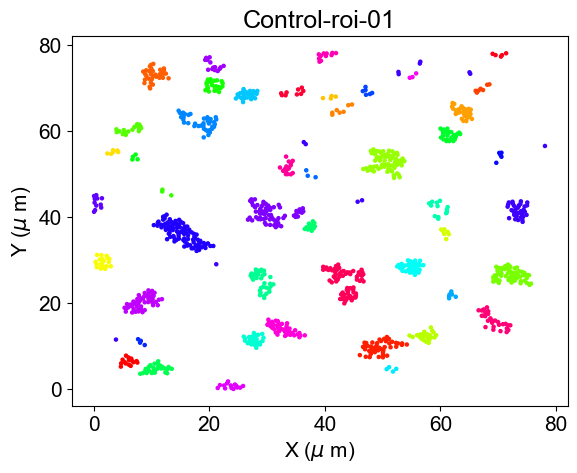

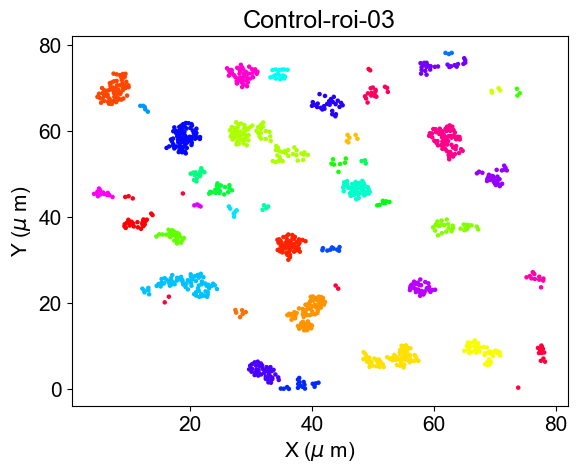

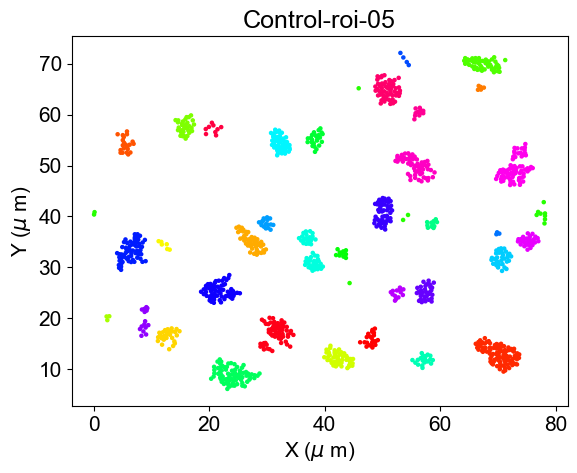

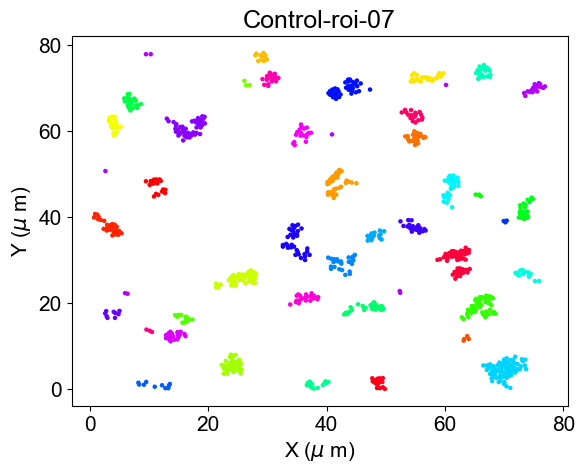

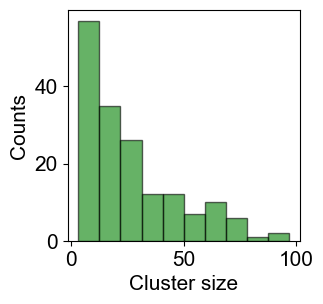

Total number of clusters:  168
Total number of clusters with at least  40  points is: 38


In [44]:
visualize_clustering_performance(points_size_dict, min_num_per_cluster=40)

CramerVonMisesResult(statistic=0.16652315917099972, pvalue=0.34294946582779706)


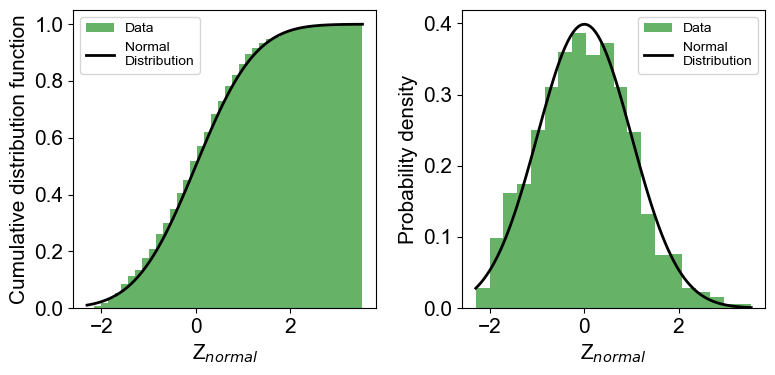

CramerVonMisesResult(statistic=1.9717145996951173, pvalue=1.4707345811437733e-05)


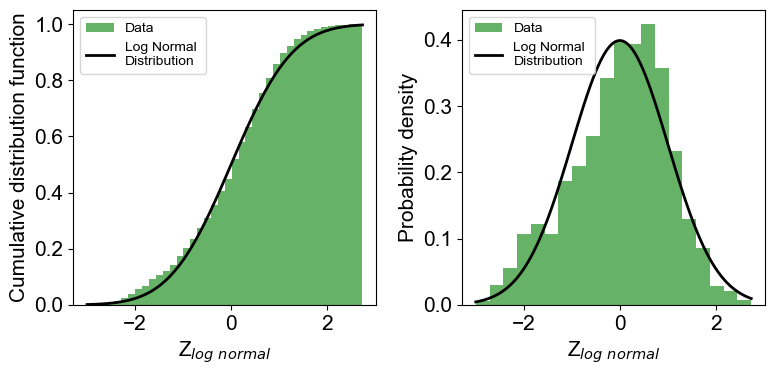

CramerVonMisesResult(statistic=10.227854240023602, pvalue=2.6603940161962214e-09)


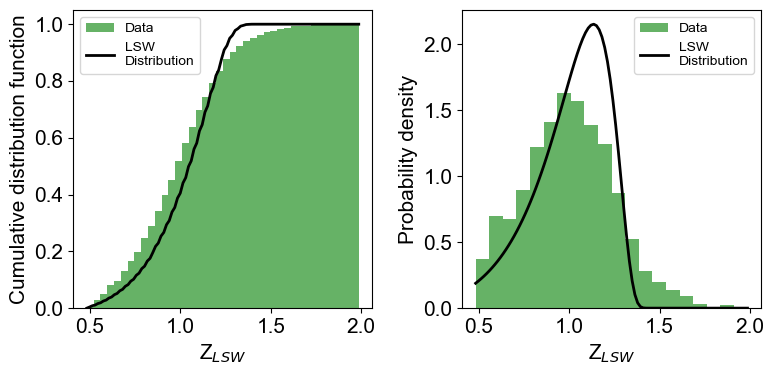

In [45]:
fit_and_compare_distributions(points_size_dict, min_num_per_cluster=40, figname='Control_size_distribution_ccv')

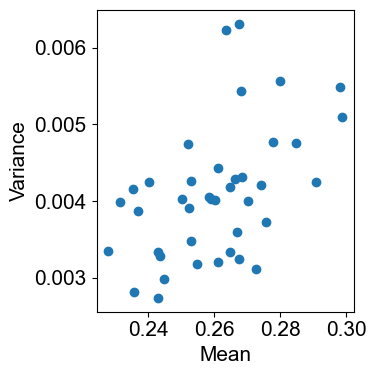

Correlation coefficient: [[1.         0.49760501]
 [0.49760501 1.        ]]


/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/seaborn/categorical.py:3543: UserWarning: 7.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


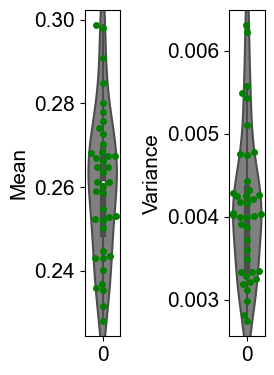

In [48]:
visualize_within_cluster_stats(points_size_dict, min_num_per_cluster=40)

In [59]:
print(0.004**0.5/0.27)

0.23424278964210216


## Transcription inhibition experiments

In [49]:
dataset = pd.read_csv('Data/transcriptional_inhibition_data.csv')

dataset['centroid_r'] = dataset['centroid_r']*micron_per_pixel
dataset['centroid_c'] = dataset['centroid_c']*micron_per_pixel

dataset['radius'] = np.divide(dataset['pixels'], np.pi)**0.5
dataset['radius(microns)'] = dataset['radius']*micron_per_pixel
dataset['diameter(microns)'] = 2.0*dataset['radius(microns)']

dataset['sample_type'] = [val[0] for val in dataset['sample'].str.split('-')]

# Drop all elements of the dataset that are not control data
dataset = dataset.drop(dataset[dataset['sample_type'] != 'Inhib'].index)
dataset.head()

,sample,spot_id,pixels,mean_intensity,centroid_r,centroid_c,microns,radius,radius(microns),diameter(microns),sample_type
4369,Inhib-roi-01,1,35,0.023542,0.170213,73.787234,0.063299,3.337791,0.142034,0.284067,Inhib
4370,Inhib-roi-01,2,24,0.018982,0.510638,73.574468,0.043405,2.763953,0.117615,0.235230,Inhib
4371,Inhib-roi-01,3,56,0.018730,0.638298,74.212766,0.101279,4.222008,0.179660,0.359320,Inhib
4372,Inhib-roi-01,4,63,0.020038,0.978723,70.680851,0.113938,4.478116,0.190558,0.381116,Inhib
4373,Inhib-roi-01,5,26,0.014923,1.106383,73.787234,0.047022,2.876814,0.122418,0.244835,Inhib


In [50]:
key_list = dataset['sample'].unique()
print(key_list)

points_size_dict = {'points': {}, 'size': {}, 'clusters': {}}

for key in key_list:

    points_size_dict['points'][key] = np.array([dataset['centroid_r'][dataset['sample']==key],
                                                dataset['centroid_c'][dataset['sample']==key]], 
                                               dtype=float).transpose()
    
    points_size_dict['size'][key] = np.array(dataset['diameter(microns)'][dataset['sample']==key])
    points_size_dict['clusters'][key] = cluster_points(points_size_dict['points'][key])

['Inhib-roi-01' 'Inhib-roi-03' 'Inhib-roi-05' 'Inhib-roi-07']


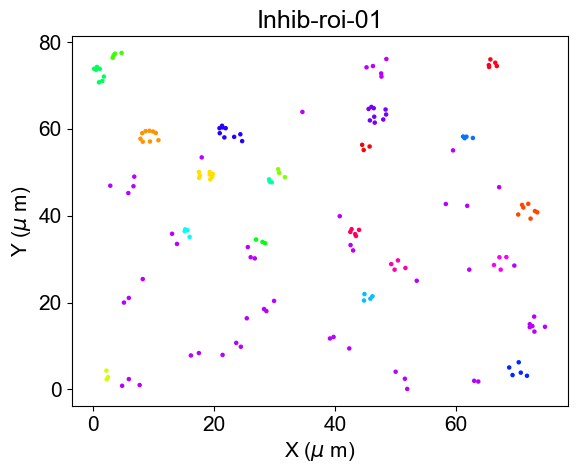

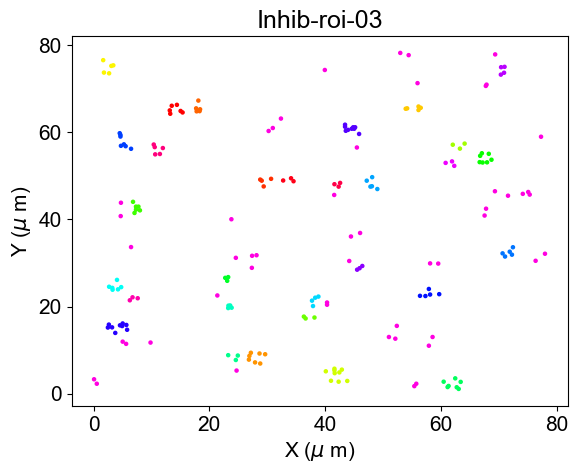

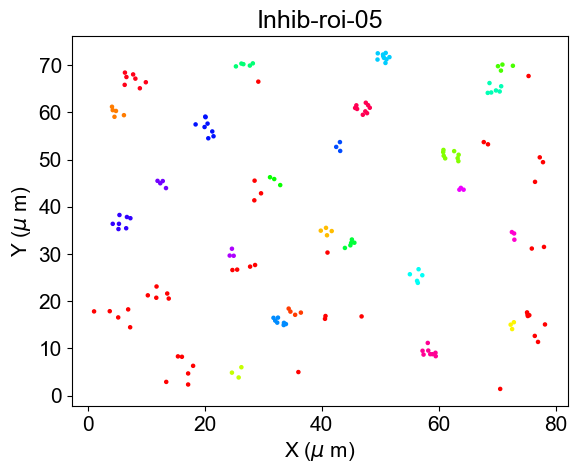

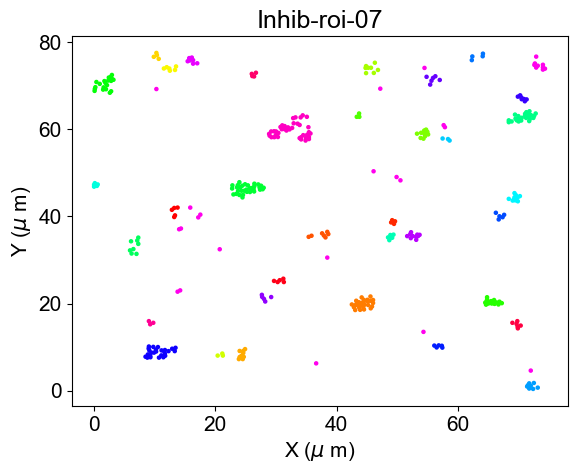

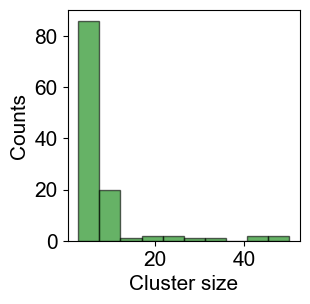

Total number of clusters:  117
Total number of clusters with at least  5  points is: 50


In [51]:
visualize_clustering_performance(points_size_dict, min_num_per_cluster=5)

CramerVonMisesResult(statistic=0.09494817884699236, pvalue=0.6103712906721828)


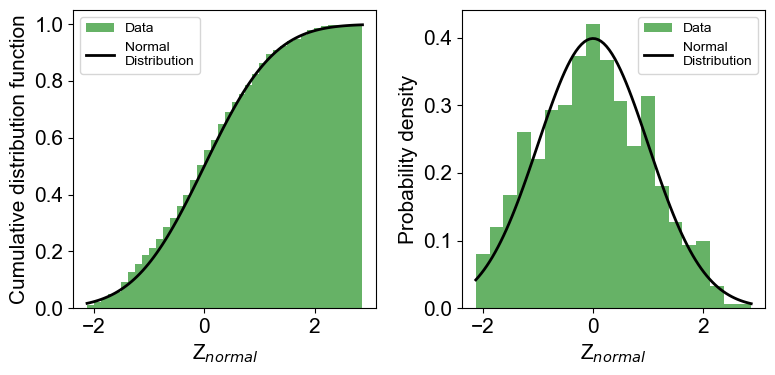

CramerVonMisesResult(statistic=0.6695643867263403, pvalue=0.015074839119712524)


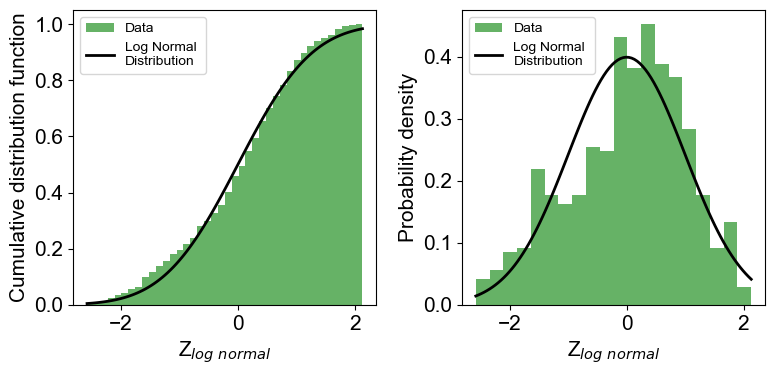

CramerVonMisesResult(statistic=3.0065625925662327, pvalue=6.901493598832076e-08)


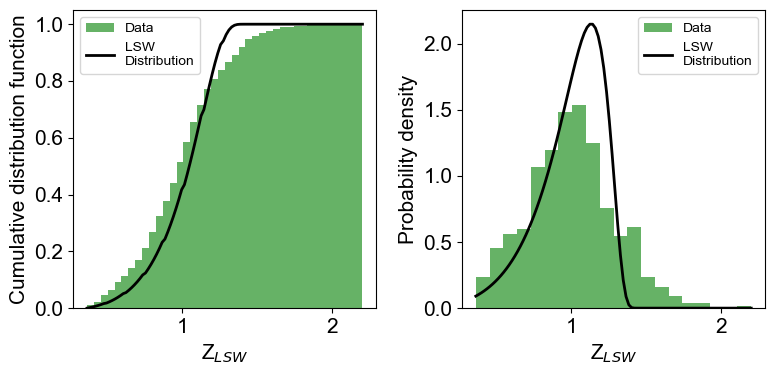

In [52]:
fit_and_compare_distributions(points_size_dict, min_num_per_cluster=5, figname='Inhibited_size_distribution_ccv')

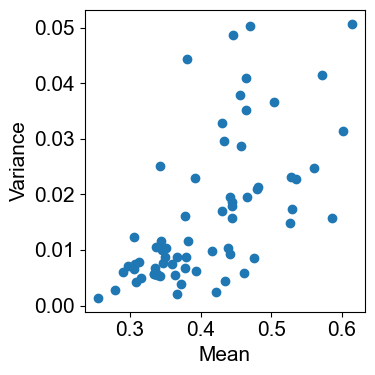

Correlation coefficient: [[1.         0.62910819]
 [0.62910819 1.        ]]


/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/seaborn/categorical.py:3543: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/seaborn/categorical.py:3543: UserWarning: 8.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


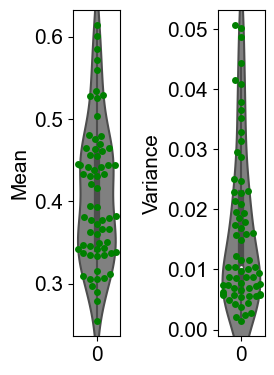

In [56]:
visualize_within_cluster_stats(points_size_dict, min_num_per_cluster=5)

In [61]:
print(0.01**0.5/0.4)

0.25


# Mutation data v2 - new segmentation by Jon

In [ ]:
dataset1 = pd.read_csv('Data/Mutation_data_v2/dish1-combined.csv')
dataset1['diameter(microns)'] = 2.0*np.divide(dataset1['Area'], np.pi)**0.5
dataset1['sample_type'] = 'dish1'
dataset2 = pd.read_csv('Data/Mutation_data_v2/dish2-combined.csv')
dataset2['diameter(microns)'] = 2.0*np.divide(dataset2['Area'], np.pi)**0.5
dataset2['sample_type'] = 'dish2'
dataset = pd.concat([dataset1, dataset2])
dataset.head()

In [ ]:
sns.violinplot(x="sample_type", y="diameter(microns)", data=dataset, color="0.8")
# sns.swarmplot(x="sample_type", y="diameter(microns)", data=dataset, size=0.1)
plt.show()
plt.close()

### Analyzing dish1

In [ ]:
key_list = dataset1['Sample'].unique()
print(key_list)

points_size_dict = {'points': {}, 'size': {}, 'clusters': {}}

for key in key_list:

    points_size_dict['points'][key] = np.array([dataset1['X'][dataset1['Sample']==key],
                                                dataset1['Y'][dataset1['Sample']==key]], 
                                               dtype=float).transpose()
    
    points_size_dict['size'][key] = np.array(dataset1['diameter(microns)'][dataset1['Sample']==key])
    points_size_dict['clusters'][key] = cluster_points(points_size_dict['points'][key], min_samples=10)

In [ ]:
# Visualize clustering performance

cluster_sizes = []

for key in points_size_dict['points'].keys(): 
    
    clusters = points_size_dict['clusters'][key]
    print(clusters[0:100])
    points = points_size_dict['points'][key]
     
    counts_of_points_in_clusters = Counter(clusters)
    cluster_sizes += [counts for counts in counts_of_points_in_clusters.values()]

    # Coloring clusters randomly
    color_array = np.arange(np.max(clusters)+1)
    np.random.shuffle(color_array)
    color_assignments = [color_array[clust_num] for clust_num in clusters]

    # Visualize the clusters
    plt.scatter(points[:, 0], points[:, 1], s=5, c=color_assignments, cmap='hsv')
    plt.xlabel(r'X ($\mu$ m)')
    plt.ylabel(r'Y ($\mu$ m)')
    plt.title(key)
    plt.show()
    plt.close()

    # Filter out points that do not belong to any cluster 
    # i.e. entries that are -1 in the list 'clusters'
    indices_to_retain = np.where(clusters >= 0)[0]
    # Filter out clusters that have small average sizes i.e. < 0.2 microns
    for cluster_num in np.unique(clusters):
        this_cluster_indices = np.where(clusters == cluster_num)[0]
#         if np.mean(size[this_cluster_indices]) < 0.2:
#             indices_to_retain = np.array([idx for idx in indices_to_retain if idx not in this_cluster_indices])
            
    color_assignments = [color_array[clust_num] for clust_num in clusters[indices_to_retain]]    
    
    # Visualize the clusters
    plt.scatter(points[indices_to_retain, 0], points[indices_to_retain, 1], s=5, c=color_assignments, cmap='hsv')
    plt.xlabel(r'X ($\mu$ m)')
    plt.ylabel(r'Y ($\mu$ m)')
    plt.title(key)
    plt.show()
    plt.close()
    
fig, axs = plt.subplots(1,1,figsize=(3,3))
axs.hist(cluster_sizes, edgecolor='k', color='g', alpha=0.6)
axs.set_xlabel('Cluster size')
axs.set_ylabel('Counts')
plt.show()
plt.close()

print('Total number of clusters: ', str(len(cluster_sizes)))

min_num_per_cluster = 40
print('Total number of clusters with at least ', str(min_num_per_cluster), ' points is:' ,str(len(np.where(np.array(cluster_sizes) > min_num_per_cluster)[0])))

## Analyzing dish2

In [ ]:
key_list = dataset2['Sample'].unique()
print(key_list)

points_size_dict = {'points': {}, 'size': {}, 'clusters': {}}

for key in key_list:

    points_size_dict['points'][key] = np.array([dataset2['X'][dataset2['Sample']==key],
                                                dataset2['Y'][dataset2['Sample']==key]], 
                                               dtype=float).transpose()
    
    points_size_dict['size'][key] = np.array(dataset1['diameter(microns)'][dataset2['Sample']==key])
    points_size_dict['clusters'][key] = cluster_points(points_size_dict['points'][key], min_samples=10)

In [ ]:
# Visualize clustering performance

cluster_sizes = []

for key in points_size_dict['points'].keys(): 
    
    clusters = points_size_dict['clusters'][key]
    print(clusters[0:100])
    points = points_size_dict['points'][key]
     
    counts_of_points_in_clusters = Counter(clusters)
    cluster_sizes += [counts for counts in counts_of_points_in_clusters.values()]

    # Coloring clusters randomly
    color_array = np.arange(np.max(clusters)+1)
    np.random.shuffle(color_array)
    color_assignments = [color_array[clust_num] for clust_num in clusters]

    # Visualize the clusters
    plt.scatter(points[:, 0], points[:, 1], s=5, c=color_assignments, cmap='hsv')
    plt.xlabel(r'X ($\mu$ m)')
    plt.ylabel(r'Y ($\mu$ m)')
    plt.title(key)
    plt.show()
    plt.close()

    # Filter out points that do not belong to any cluster 
    # i.e. entries that are -1 in the list 'clusters'
    indices_to_retain = np.where(clusters >= 0)[0]
    # Filter out clusters that have small average sizes i.e. < 0.2 microns
    for cluster_num in np.unique(clusters):
        this_cluster_indices = np.where(clusters == cluster_num)[0]
#         if np.mean(size[this_cluster_indices]) < 0.2:
#             indices_to_retain = np.array([idx for idx in indices_to_retain if idx not in this_cluster_indices])
            
    color_assignments = [color_array[clust_num] for clust_num in clusters[indices_to_retain]]    
    
    # Visualize the clusters
    plt.scatter(points[indices_to_retain, 0], points[indices_to_retain, 1], s=5, c=color_assignments, cmap='hsv')
    plt.xlabel(r'X ($\mu$ m)')
    plt.ylabel(r'Y ($\mu$ m)')
    plt.title(key)
    plt.show()
    plt.close()
    
fig, axs = plt.subplots(1,1,figsize=(3,3))
axs.hist(cluster_sizes, edgecolor='k', color='g', alpha=0.6)
axs.set_xlabel('Cluster size')
axs.set_ylabel('Counts')
plt.show()
plt.close()

print('Total number of clusters: ', str(len(cluster_sizes)))

min_num_per_cluster = 40
print('Total number of clusters with at least ', str(min_num_per_cluster), ' points is:' ,str(len(np.where(np.array(cluster_sizes) > min_num_per_cluster)[0])))

**Note:** The filtering works beautifully!!

## Function to calculate distance to nearest neighbor

In [ ]:
# Function to calculate distance to the nearest neighbor 

def calculate_distances(points):
    
    min_distances = np.array([], dtype=float)
    
    # Calculate pairwise distances using the Euclidean distance metric
    distances = distance.cdist(points, points, 'euclidean')

    # Exclude self-distances (distances to themselves)
    np.fill_diagonal(distances, np.inf)

    # Find the minimum distance for each point
    min_distances_pairwise = np.min(distances, axis=1)
    min_distances = np.append(min_distances, min_distances_pairwise)
    
    return min_distances

## Filter out the points that do not belong to any cluster using DBSCAN and then re-analyze the data

In [ ]:
patterning_dict = {'points': {}, 'size': {}, 'cluster_sizes': {}, 'distances': {}}

key_list = dataset['Sample'].unique()

for key in key_list:
    points = np.array([dataset['X'][dataset['Sample']==key], 
                       dataset['Y'][dataset['Sample']==key]],
                      dtype=float).transpose()
    size = np.array(dataset['diameter(microns)'][dataset['Sample']==key])
    clusters = cluster_points(points, min_samples=20)
    
    # Filter out the points that do not belong to any cluster
    indices_to_retain = np.where(clusters >= 0)[0]
    # Filter out clusters that have small average sizes i.e. < 0.2 microns
    for cluster_num in np.unique(clusters):
        this_cluster_indices = np.where(clusters == cluster_num)[0]
#         if np.mean(size[this_cluster_indices]) < 0.15:
#             indices_to_retain = np.array([idx for idx in indices_to_retain if idx not in this_cluster_indices])
    
    # Get cluster size
    counts_of_points_in_clusters = Counter(clusters[indices_to_retain])
    cluster_sizes = [counts for counts in counts_of_points_in_clusters.values()]
    
    dish_key = key.split('-')[0]
    
    if dish_key in patterning_dict['points'].keys():
        patterning_dict['points'][dish_key] = np.append(patterning_dict['points'][dish_key], points[indices_to_retain])
        patterning_dict['size'][dish_key] = np.append(patterning_dict['size'][dish_key], size[indices_to_retain])
        patterning_dict['cluster_sizes'][dish_key] = np.append(patterning_dict['cluster_sizes'][dish_key], 
                                                               cluster_sizes)
        patterning_dict['distances'][dish_key] = np.append(patterning_dict['distances'][dish_key],
                                                      calculate_distances(points[indices_to_retain]))
    else:
        patterning_dict['points'][dish_key] = points[indices_to_retain]
        patterning_dict['size'][dish_key] = size[indices_to_retain]
        patterning_dict['cluster_sizes'][dish_key] = cluster_sizes
        patterning_dict['distances'][dish_key] = calculate_distances(points[indices_to_retain])
    
# Make size violin plot after filtering the data
df = pd.DataFrame.from_dict({"dish1": patterning_dict['size']['dish1'],
                             "dish2": patterning_dict['size']['dish2']}, 
                            orient='index').T
fig, axs = plt.subplots(1, 2, figsize=(6, 4))
sns.violinplot(data=df, ax=axs[0], color="0.8")
sns.violinplot(x="sample_type", y="diameter(microns)", data=dataset, color="0.8", ax=axs[1])
# sns.stripplot(data=df, jitter=True, ax=axs[0], size=0.3)
axs[0].set_ylabel(r'FC size ($\mu$m)')
axs[0].set_ylim(0.0, 1.0)
axs[1].set_ylabel('')
axs[1].set_ylim(0.0, 1.0)
axs[1].set_xlabel('')
plt.tight_layout()
plt.show()
plt.close()
    
# Make size violin plot after filtering the data
df = pd.DataFrame.from_dict({"dish1": patterning_dict['size']['dish1'],
                             "dish2": patterning_dict['size']['dish2']}, 
                            orient='index').T
df_swarm = pd.DataFrame.from_dict({"dish1": choice(patterning_dict['size']['dish1'], 500),
                                   "dish2": choice(patterning_dict['size']['dish2'], 500)}, 
                                    orient='index').T
fig, axs = plt.subplots(1, 1, figsize=(3, 4))
sns.violinplot(data=df, ax=axs, color="green", alpha=0.5)
sns.swarmplot(data=df_swarm, ax=axs, zorder=1, palette=['green', 'green'], size=2.5)
for violin, alpha in zip(axs.collections[::2], [0.5]*2):
    violin.set_alpha(alpha)
# sns.stripplot(data=df, jitter=True, ax=axs[0], size=0.3)
axs.set_ylabel(r'FC size ($\mu$m)')
axs.set_ylim(0.0, 1.5)
plt.tight_layout()
plt.show()
plt.close()
print(ttest_ind(patterning_dict['size']['dish1'], patterning_dict['size']['dish2'], equal_var=False))
print(np.mean(patterning_dict['size']['dish1']))
print(np.mean(patterning_dict['size']['dish2']))

# Make cluster size violin plot after filtering the data
df = pd.DataFrame.from_dict({"dish1": patterning_dict['distances']['dish1'],
                             "dish2": patterning_dict['distances']['dish2']}, 
                            orient='index').T
df_swarm = pd.DataFrame.from_dict({"dish1": choice(patterning_dict['distances']['dish1'], 500),
                                   "dish2": choice(patterning_dict['distances']['dish2'], 500)}, 
                                    orient='index').T

# Create the violin plot
fig, axs = plt.subplots(1, 1, figsize=(3, 4))
sns.violinplot(data=df, color='steelblue')
sns.swarmplot(data=df_swarm, ax=axs, zorder=1, palette=['steelblue', 'steelblue'], size=2.5)
for violin, alpha in zip(axs.collections[::2], [0.5]*2):
    violin.set_alpha(alpha)
# sns.violinplot(x="sample_type", y="diameter(microns)", data=dataset, color="0.8", ax=axs[1])
axs.set_ylabel(r'FC spacing ($\mu$m)')
axs.set_ylim(0.0, 2.0)
plt.tight_layout()
plt.show()
plt.close()
print(ttest_ind(patterning_dict['distances']['dish1'], patterning_dict['distances']['dish2'], equal_var=False))

# Make distance violin plot after filtering the data
df = pd.DataFrame.from_dict({"dish1": patterning_dict['cluster_sizes']['dish1'],
                             "dish2": patterning_dict['cluster_sizes']['dish2']}, 
                            orient='index').T

# Create the violin plot
fig, axs = plt.subplots(1, 1, figsize=(3, 4))
sns.violinplot(data=df, color="0.8")
sns.swarmplot(data=df, zorder=1, palette=['grey', 'grey'])
# sns.violinplot(x="sample_type", y="diameter(microns)", data=dataset, color="0.8", ax=axs[1])
axs.set_ylabel(r'FC number')
# axs.set_ylim(10.0, 150.0)
plt.tight_layout()
plt.show()
plt.close()
print(ttest_ind(patterning_dict['cluster_sizes']['dish1'], patterning_dict['cluster_sizes']['dish2'], equal_var=False))